In [1]:
using Distributions
using Random
using Statistics
using Plots
using DataFrames
using VegaLite
using Plots
using StatsPlots
using DataFramesMeta
using CategoricalArrays
using GLM
using StatsModels

## Distribution of probability of default of customers

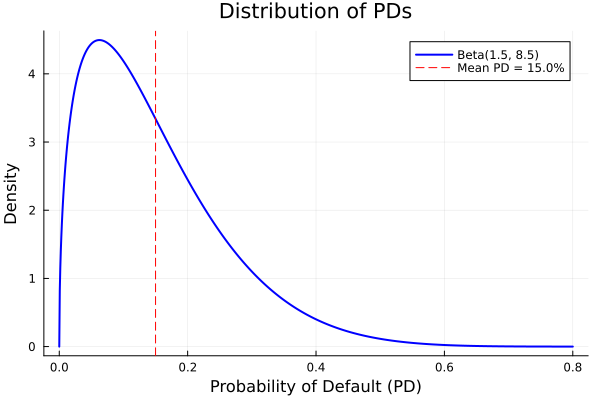

In [3]:
# Create PD distribution
beta_dist = Beta(1.5, 8.5)

# Data
x = range(0, 0.8, length=1000)  
pdf_values = pdf.(beta_dist, x)  

# Plot
plot(x, pdf_values, 
     label="Beta(1.5, 8.5)", 
     linewidth=2, 
     color=:blue,
     xlabel="Probability of Default (PD)", 
     ylabel="Density",
     title="Distribution of PDs",
     legend=:topright)

# Mean
mean_pd = mean(beta_dist)
vline!([mean_pd], label="Mean PD = $(round(mean_pd*100, digits=2))%", linestyle=:dash, color=:red)

**Parameters:**
- `r`: interest rate of the product - decision variable
- `t`: probability of default of the customer (accept PDs <= t) - decision variable
- `N`: number of customers - fixed = **10.000 customers**
- `A`: loan amount - fixed = **50.000 PLN**
- `y`: duration of loan (year) - fixed = **5 years**
- `LGD_rate`: lost given default rate - fixed = **55%**
- `c_op`: cost of operation - fixed = **400 PLN/loan**
- `lambda`: risk aversion coefficient of penalty - fixed = **0.3** 

## Simulate funcitons

In [6]:
function evaluate_policy(r, t;
                         N=10_000,
                         A=50_000.0, y=5,
                         LGD_rate=0.55, c_op=400.0,
                         lambda=0.3,
                         beta_a=1.5, beta_b=8.5,
                         rng=MersenneTwister())
    
    PDs = rand(rng, Beta(beta_a, beta_b), N)

    accepted = 0
    expected_profit = 0.0
    total_risk_exposure = 0.0

    interest_income = r * A * y  
    LGD = LGD_rate * A                    

    for i in 1:N
        if PDs[i] <= t
            accepted += 1
            gain = (1 - PDs[i]) * interest_income
            loss = PDs[i] * LGD
            expected_profit += gain - loss - c_op
            total_risk_exposure += PDs[i] * LGD
        end
    end

    acceptance_rate = accepted / N
    objective_value = expected_profit - lambda * total_risk_exposure

    return (
        expected_profit = expected_profit,
        acceptance_rate = acceptance_rate,
        total_risk_exposure = total_risk_exposure,
        objective_value = objective_value
    )
end

evaluate_policy (generic function with 1 method)

In [7]:
function run_sims(r, t;
                  sims=1000,
                  N=10_000,
                  A=50_000.0, y=5,
                  LGD_rate=0.55, c_op=400.0,
                  lambda=0.3,
                  beta_a=1.5, beta_b=8.5,
                  seed=1234)

    rng = MersenneTwister(seed)

    results = [
        evaluate_policy(r, t;
            N=N, A=A, y=y,
            LGD_rate=LGD_rate, c_op=c_op,
            lambda=lambda,
            beta_a=beta_a, beta_b=beta_b,
            rng=rng
        )
        for _ in 1:sims
    ]

    # Expected value
    mean_expected_profit = mean(getfield.(results, :expected_profit))
    mean_acceptance_rate = mean(getfield.(results, :acceptance_rate))
    mean_total_risk = mean(getfield.(results, :total_risk_exposure))
    mean_objective_value = mean(getfield.(results, :objective_value))

    return (
        expected_profit = mean_expected_profit,
        acceptance_rate = mean_acceptance_rate,
        total_risk_exposure = mean_total_risk,
        objective_value = mean_objective_value
    )
end


run_sims (generic function with 1 method)

## Constraints

| Variable          | Range                 | Department                | Reason |
|-----------------------------------|----------------------------------|------------------------------|--------------|
| `interest rate`     | Minimum 6%, maximum 12%          | Finance & Sales              | Ensures profitability while remaining competitive in the market |
| `PD threshold`      | Approve only customers with PD ≤ 15% | Risk Management              | Controls credit risk and prevents approving overly risky clients |
| `acceptance_rate`          | At least 30%                     | Sales / Business Development | Ensures marketing effectiveness and customer acquisition |
| `total_risk_exposure`       | Maximum 4,000,000 PLN               | Risk Management              | Limits total portfolio risk exposure |
| `expected_profit`           | Minimum expected profit of 2,000,000 PLN | Finance                  | Guarantees the product is profitable after cost of capital and credit losses |


## Finding optimal policy (r, t)

In [10]:
# Range
interest_rates = 0.06:0.01:0.12  
pd_thresholds = 0.05:0.01:0.15  

# Result df
results_df = DataFrame(
    interest_rate = Float64[],
    pd_threshold = Float64[],
    expected_profit = Float64[],
    acceptance_rate = Float64[],
    total_risk_exposure = Float64[],
    objective_value = Float64[]
)

# Apply run_sims
for r in interest_rates, t in pd_thresholds
    result = run_sims(r, t)
    push!(results_df, (
        interest_rate = r,
        pd_threshold = t,
        expected_profit = result.expected_profit,
        acceptance_rate = result.acceptance_rate,
        total_risk_exposure = result.total_risk_exposure,
        objective_value = result.objective_value
    ))
end

# Rescale
results_df[!, :expected_profit] ./= 1_000_000
results_df[!, :total_risk_exposure] ./= 1_000_000
results_df[!, :objective_value] ./= 1_000_000


# Filter constraints
filtered = filter(row ->
    row.acceptance_rate ≥ 0.30 &&
    row.total_risk_exposure ≤ 4 &&
    row.expected_profit ≥ 2,
    results_df
)

# Optimal solution
best_row = sort(filtered, :objective_value, rev=true)[1, :]

println("Optimal policy found:")
println(best_row)

Optimal policy found:
DataFrameRow
 Row │ interest_rate  pd_threshold  expected_profit  acceptance_rate  total_risk_exposure  objective_value 
     │ Float64        Float64       Float64          Float64          Float64              Float64         
─────┼─────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │          0.12          0.08          83.2765         0.307941              3.76591          82.1467


In [11]:
top_policy = sort(filtered, :objective_value, rev=true)

first(top_policy, 5)

Row,interest_rate,pd_threshold,expected_profit,acceptance_rate,total_risk_exposure,objective_value
,Float64,Float64,Float64,Float64,Float64,Float64
1,0.12,0.08,83.2765,0.307941,3.76591,82.1467
2,0.11,0.08,75.9203,0.307941,3.76591,74.7905
3,0.1,0.08,68.5641,0.307941,3.76591,67.4343
4,0.09,0.08,61.2079,0.307941,3.76591,60.0782
5,0.08,0.08,53.8518,0.307941,3.76591,52.722


WebIO._IJuliaInit()

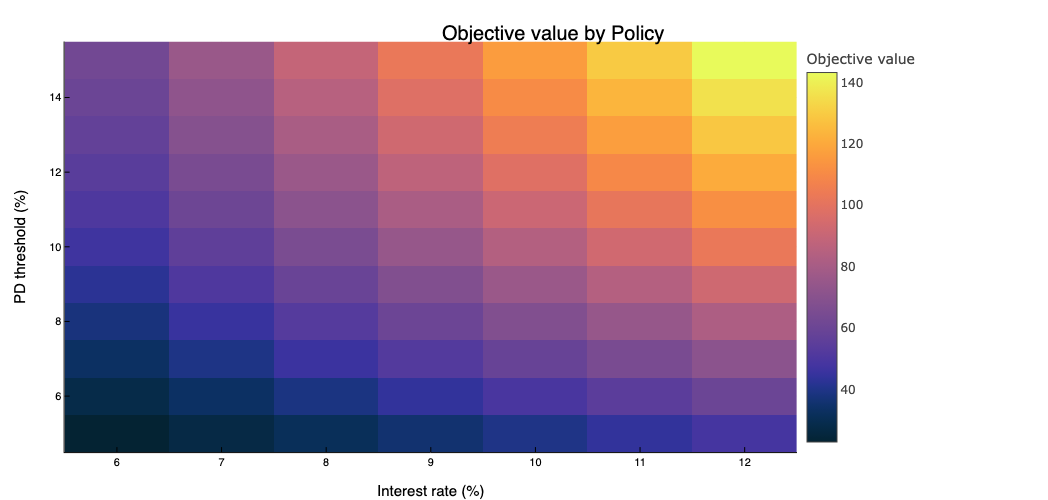

In [12]:
plotlyjs()  

# Get sorted unique r and t
interest_rates = sort(unique(results_df.interest_rate))
pd_thresholds = sort(unique(results_df.pd_threshold))

# Matrix Z with t and r
Z = [
    results_df[(results_df.interest_rate .== r) .& (results_df.pd_threshold .== t), :objective_value][1]
    for t in pd_thresholds, r in interest_rates  
]

# Heatmap
heatmap(
    interest_rates .* 100,   
    pd_thresholds .* 100,
    Z,
    xlabel = "Interest rate (%)",
    ylabel = "PD threshold (%)",
    title = "Objective value by Policy",
    colorbar_title = "Objective value",
    c = :thermal,   
    size = (600, 500)
)

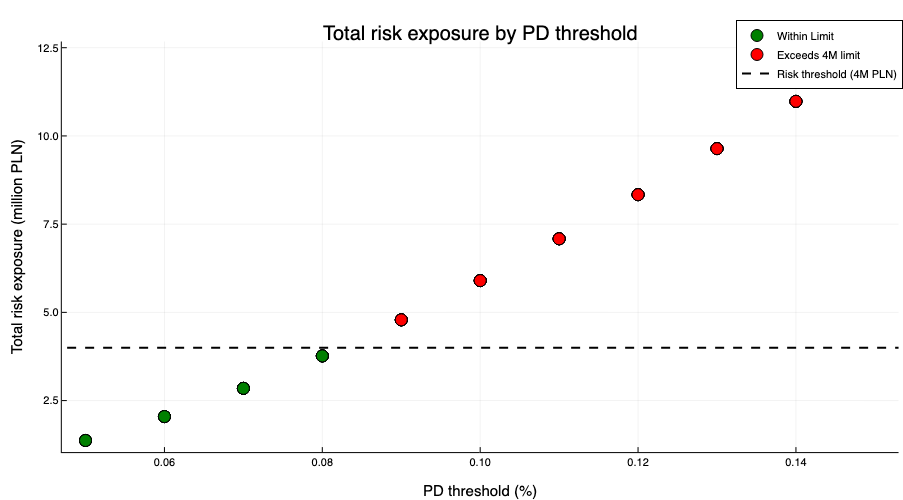

In [13]:
# Risk threshold
risk_threshold = 4.0  

x_within = results_df.pd_threshold[results_df.total_risk_exposure .<= risk_threshold]
y_within = results_df.total_risk_exposure[results_df.total_risk_exposure .<= risk_threshold]

x_exceed = results_df.pd_threshold[results_df.total_risk_exposure .> risk_threshold] 
y_exceed = results_df.total_risk_exposure[results_df.total_risk_exposure .> risk_threshold]

# Plot 
p = scatter(
    x_within, y_within,
    label = "Within Limit",
    markercolor = :green,
    markersize = 6,
    xlabel = "PD threshold (%)",
    ylabel = "Total risk exposure (million PLN)",
    title = "Total risk exposure by PD threshold",
    legend = :topright,
    size = (800, 500)
)

# Exeed points
scatter!(p, x_exceed, y_exceed,
    label = "Exceeds 4M limit",
    markercolor = :red,
    markersize = 6
)

# Threshold line
hline!(p, [risk_threshold],
    label = "Risk threshold (4M PLN)",
    linestyle = :dash,
    linecolor = :black,
    linewidth = 2
)

## What-if analysis

### Distribution of PD

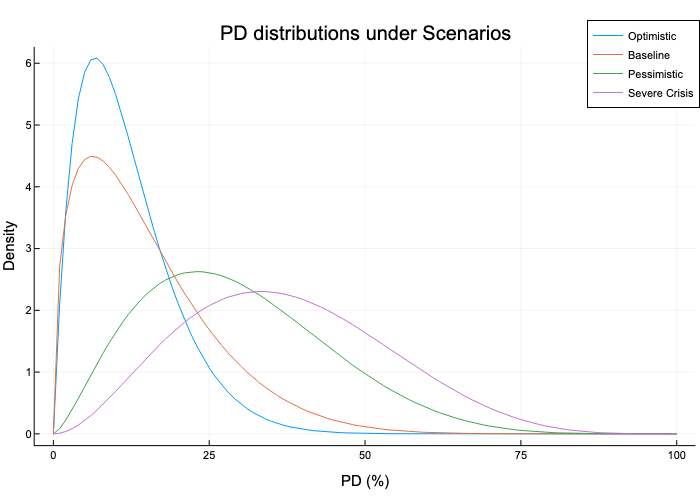

In [16]:
# Market scenarios
scenarios = [
    ("Optimistic",    2.0, 15.0),  # Mean ≈ 7%
    ("Baseline",      1.5, 8.5),   # Mean ≈ 15%
    ("Pessimistic",   2.5, 6.0),   # Mean ≈ 29%
    ("Severe Crisis", 3.0, 5.0)    # Mean ≈ 38%
]

pd_range = 0:0.01:1

plot()
for (name, a, b) in scenarios
    pd_dist = pdf.(Beta(a, b), pd_range)
    plot!(pd_range .* 100, pd_dist,
        label=name,
        xlabel="PD (%)", ylabel="Density",
        title="PD distributions under Scenarios")
end
display(plot!())


In [17]:
optimal_results_with_constraints = DataFrame(
    scenario = String[],
    beta_a = Float64[],
    beta_b = Float64[],
    interest_rate = Float64[],
    pd_threshold = Float64[],
    expected_profit = Float64[],
    acceptance_rate = Float64[],
    total_risk_exposure = Float64[],
    objective_value = Float64[]
)

for (name, beta_a, beta_b) in scenarios
    println("Running scenario: $name")
    temp_results = DataFrame()

    for r in 0.06:0.01:0.12
        for t in 0.03:0.01:0.12
            res = run_sims(r, t; beta_a=beta_a, beta_b=beta_b)
            push!(temp_results, (
                scenario = name,
                beta_a = beta_a,
                beta_b = beta_b,
                interest_rate = r,
                pd_threshold = t,
                objective_value = res.objective_value,
                acceptance_rate = res.acceptance_rate,
                total_risk_exposure = res.total_risk_exposure,
                expected_profit = res.expected_profit
            ))
        end
    end

    # Filter constraints
    filtered = filter(row ->
        row.acceptance_rate ≥ 0.30 &&
        row.total_risk_exposure ≤ 4_000_000 &&
        row.expected_profit ≥ 2_000_000,
        temp_results
    )

    if nrow(filtered) > 0
        best_row = filtered[argmax(filtered.objective_value), :]
        push!(optimal_results_with_constraints, best_row)
    else
        println("No feasible solution for scenario: $name")
    end
end

# Rescale
optimal_results_with_constraints[!, :expected_profit] ./= 1_000_000
optimal_results_with_constraints[!, :total_risk_exposure] ./= 1_000_000
optimal_results_with_constraints[!, :objective_value] ./= 1_000_000

# Display
optimal_results_with_constraints

Running scenario: Optimistic
Running scenario: Baseline
Running scenario: Pessimistic
No feasible solution for scenario: Pessimistic
Running scenario: Severe Crisis
No feasible solution for scenario: Severe Crisis


Row,scenario,beta_a,beta_b,interest_rate,pd_threshold,expected_profit,acceptance_rate,total_risk_exposure,objective_value
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimistic,2.0,15.0,0.12,0.07,84.099,0.309656,3.61521,83.0144
2,Baseline,1.5,8.5,0.12,0.08,83.2765,0.307941,3.76591,82.1467


In [18]:
optimal_results = DataFrame(
    scenario = String[],
    beta_a = Float64[],
    beta_b = Float64[],
    interest_rate = Float64[],
    pd_threshold = Float64[],
    expected_profit = Float64[],
    acceptance_rate = Float64[],
    total_risk_exposure = Float64[],
    objective_value = Float64[]
)

for (name, beta_a, beta_b) in scenarios
    println("Running scenario: $name")
    temp_results = DataFrame()

    for r in 0.06:0.01:0.12
        for t in 0.03:0.01:0.12
            res = run_sims(r, t;
                beta_a=beta_a, beta_b=beta_b
            )
            push!(temp_results, (
                scenario=name,
                beta_a=beta_a,
                beta_b=beta_b,
                interest_rate=r,
                pd_threshold=t,
                expected_profit=res.expected_profit,
                acceptance_rate=res.acceptance_rate,
                total_risk_exposure=res.total_risk_exposure,
                objective_value=res.objective_value
            ))
        end
    end

    best_row = temp_results[argmax(temp_results.objective_value), :]
    push!(optimal_results, best_row)
end

# Rescale
optimal_results[!, :expected_profit] ./= 1_000_000
optimal_results[!, :total_risk_exposure] ./= 1_000_000
optimal_results[!, :objective_value] ./= 1_000_000

# Display
optimal_results

Running scenario: Optimistic
Running scenario: Baseline
Running scenario: Pessimistic
Running scenario: Severe Crisis


Row,scenario,beta_a,beta_b,interest_rate,pd_threshold,expected_profit,acceptance_rate,total_risk_exposure,objective_value
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimistic,2.0,15.0,0.12,0.12,151.516,0.588301,10.819,148.27
2,Baseline,1.5,8.5,0.12,0.12,123.122,0.474828,8.33479,120.621
3,Pessimistic,2.5,6.0,0.12,0.12,28.1367,0.113064,2.54917,27.372
4,Severe Crisis,3.0,5.0,0.12,0.12,10.2287,0.0416339,1.0019,9.92818


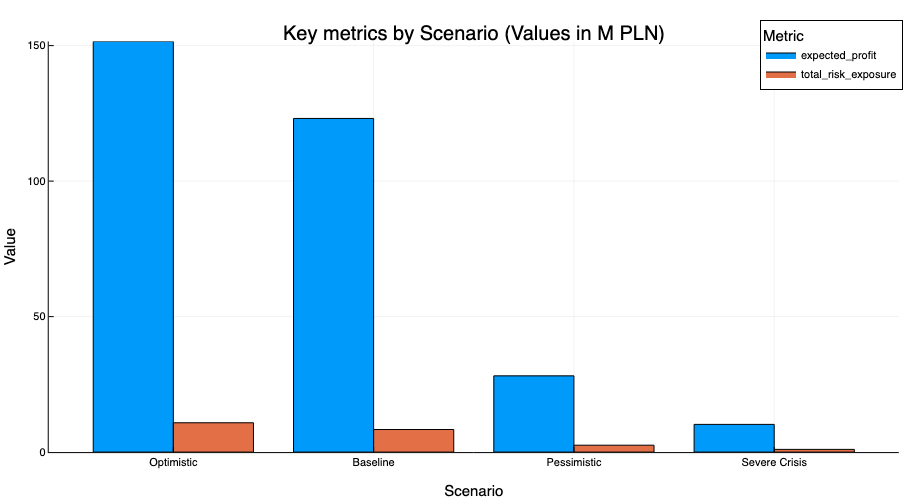

In [19]:
# Define order
desired_order = ["Optimistic", "Baseline", "Pessimistic", "Severe Crisis"]

optimal_results.scenario = categorical(optimal_results.scenario, ordered=true, levels=desired_order)

df_long = stack(optimal_results, [:expected_profit, :total_risk_exposure],
                variable_name = :metric, value_name = :value)

@df df_long groupedbar(
    :scenario,
    :value,
    group = :metric,
    xlabel = "Scenario",
    ylabel = "Value",
    bar_position = :dodge,
    legendtitle = "Metric",
    title = "Key metrics by Scenario (Values in M PLN)",
    size = (850, 500)
)

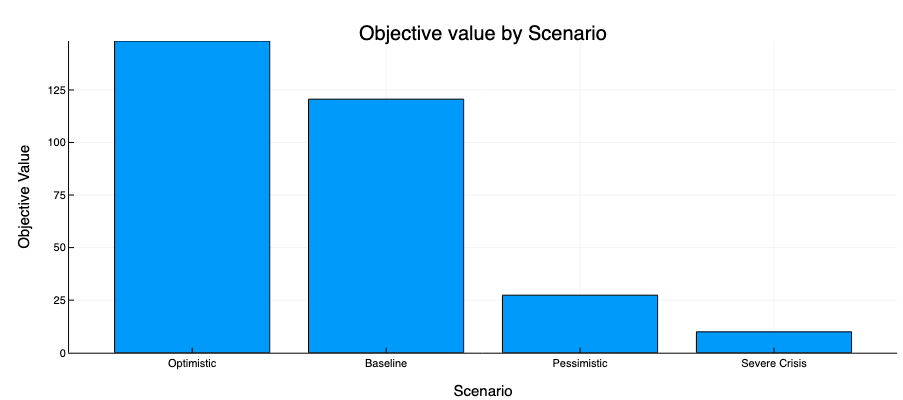

In [20]:
@df optimal_results bar(
    :scenario,
    :objective_value,
    xlabel = "Scenario",
    ylabel = "Objective Value",
    title = "Objective value by Scenario",
    markersize = 8,
    legend = false
)


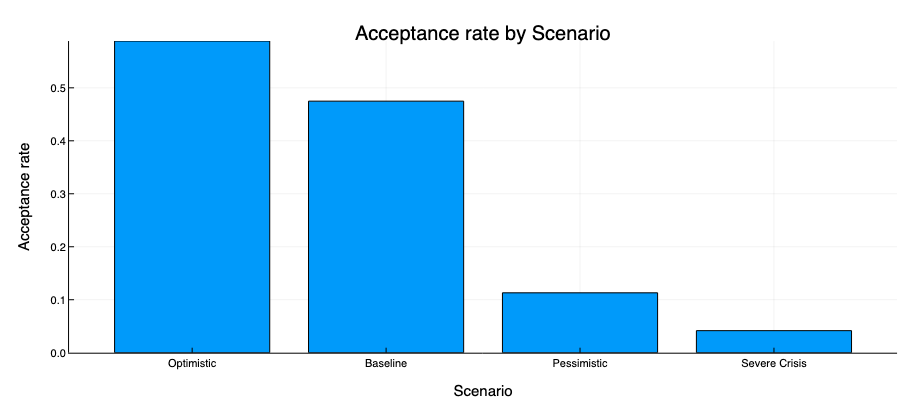

In [21]:
@df optimal_results bar(
    :scenario,
    :acceptance_rate,
    xlabel = "Scenario",
    ylabel = "Acceptance rate",
    title = "Acceptance rate by Scenario",
    markersize = 8, legend = false
)


In [22]:
optimal_results_no_ar = DataFrame(
    scenario = String[],
    beta_a = Float64[],
    beta_b = Float64[],
    interest_rate = Float64[],
    pd_threshold = Float64[],
    expected_profit = Float64[],
    acceptance_rate = Float64[],
    total_risk_exposure = Float64[],
    objective_value = Float64[]
)

for (name, beta_a, beta_b) in scenarios
    println("Running scenario: $name")
    temp_results = DataFrame()

    for r in 0.06:0.01:0.12
        for t in 0.03:0.01:0.12
            res = run_sims(r, t; beta_a=beta_a, beta_b=beta_b)
            push!(temp_results, (
                scenario = name,
                beta_a = beta_a,
                beta_b = beta_b,
                interest_rate = r,
                pd_threshold = t,
                objective_value = res.objective_value,
                acceptance_rate = res.acceptance_rate,
                total_risk_exposure = res.total_risk_exposure,
                expected_profit = res.expected_profit
            ))
        end
    end

    # Filter constraints
    filtered = filter(row ->
        row.total_risk_exposure ≤ 4_000_000 &&
        row.expected_profit ≥ 2_000_000,
        temp_results
    )

    if nrow(filtered) > 0
        best_row = filtered[argmax(filtered.objective_value), :]
        push!(optimal_results_no_ar, best_row)
    else
        println("No feasible solution for scenario: $name")
    end
end

# Rescale
optimal_results_no_ar[!, :expected_profit] ./= 1_000_000
optimal_results_no_ar[!, :total_risk_exposure] ./= 1_000_000
optimal_results_no_ar[!, :objective_value] ./= 1_000_000

# Display
optimal_results_no_ar

Running scenario: Optimistic
Running scenario: Baseline
Running scenario: Pessimistic
Running scenario: Severe Crisis


Row,scenario,beta_a,beta_b,interest_rate,pd_threshold,expected_profit,acceptance_rate,total_risk_exposure,objective_value
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Optimistic,2.0,15.0,0.12,0.07,84.099,0.309656,3.61521,83.0144
2,Baseline,1.5,8.5,0.12,0.08,83.2765,0.307941,3.76591,82.1467
3,Pessimistic,2.5,6.0,0.12,0.12,28.1367,0.113064,2.54917,27.372
4,Severe Crisis,3.0,5.0,0.12,0.12,10.2287,0.0416339,1.0019,9.92818


### Risk aversion 

In [24]:
# Risk aversion list
lambda_scenarios = [
    ("Risk-neutral", 0.0),
    ("Low aversion", 0.1),
    ("Moderate aversion", 0.3),
    ("High aversion", 0.6),
    ("Extreme aversion", 1.0),
    ("Stress testing - crisis", 3.0)
]

# Result df
optimal_lambda_results = DataFrame(
    scenario = String[],
    lambda = Float64[],
    interest_rate = Float64[],
    pd_threshold = Float64[],
    expected_profit = Float64[],
    acceptance_rate = Float64[],
    total_risk_exposure = Float64[],
    objective_value = Float64[]
)

for (name, l) in lambda_scenarios
    println("Running lambda scenario: $name")

    temp_results = DataFrame()

    for r in 0.06:0.01:0.12
        for t in 0.03:0.01:0.12
            res = run_sims(r, t; lambda=l)
            push!(temp_results, (
                scenario = name,
                lambda = l,
                interest_rate = r,
                pd_threshold = t,
                expected_profit = res.expected_profit,
                acceptance_rate = res.acceptance_rate,
                total_risk_exposure = res.total_risk_exposure,
                objective_value = res.objective_value
            ))
        end
    end

    # Filter constraints
    filtered = filter(row ->
        row.acceptance_rate ≥ 0.30 &&
        row.total_risk_exposure ≤ 4_000_000 &&
        row.expected_profit ≥ 2_000_000,
        temp_results
    )

    if nrow(filtered) > 0
        best_row = filtered[argmax(filtered.objective_value), :]
        push!(optimal_lambda_results, best_row)
    else
        println("No feasible solution found for scenario: $name")
    end
end

# Rescale
optimal_lambda_results[!, :expected_profit] ./= 1_000_000
optimal_lambda_results[!, :total_risk_exposure] ./= 1_000_000
optimal_lambda_results[!, :objective_value] ./= 1_000_000

# Display
optimal_lambda_results

Running lambda scenario: Risk-neutral
Running lambda scenario: Low aversion
Running lambda scenario: Moderate aversion
Running lambda scenario: High aversion
Running lambda scenario: Extreme aversion
Running lambda scenario: Stress testing - crisis


Row,scenario,lambda,interest_rate,pd_threshold,expected_profit,acceptance_rate,total_risk_exposure,objective_value
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Risk-neutral,0.0,0.12,0.08,83.2765,0.307941,3.76591,83.2765
2,Low aversion,0.1,0.12,0.08,83.2765,0.307941,3.76591,82.8999
3,Moderate aversion,0.3,0.12,0.08,83.2765,0.307941,3.76591,82.1467
4,High aversion,0.6,0.12,0.08,83.2765,0.307941,3.76591,81.0169
5,Extreme aversion,1.0,0.12,0.08,83.2765,0.307941,3.76591,79.5106
6,Stress testing - crisis,3.0,0.12,0.08,83.2765,0.307941,3.76591,71.9787


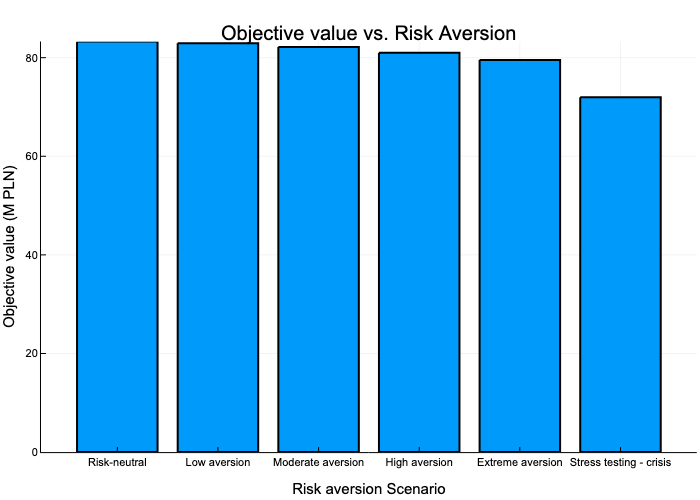

In [25]:
@df optimal_lambda_results bar(
    :scenario,
    :objective_value,
    xlabel = "Risk aversion Scenario",
    ylabel = "Objective value (M PLN)",
    title = "Objective value vs. Risk Aversion",
    legend = false,
    marker = :circle,
    lw = 2,
    size = (850, 500)
)


### Lost Given Default

In [27]:
# Experiment LGD rate
lgd_rates = [0.30, 0.40, 0.50, 0.60, 0.70, 0.80]

optimal_results_lgd = DataFrame(
    lgd_rate = Float64[],
    interest_rate = Float64[],
    pd_threshold = Float64[],
    expected_profit = Float64[],
    acceptance_rate = Float64[],
    total_risk_exposure = Float64[],
    objective_value = Float64[]
)

for lgd in lgd_rates
    results_df = DataFrame()

    for r in 0.08:0.01:0.12, t in 0.05:0.01:0.12
        result = run_sims(r, t;
            A=50_000.0, y=5,
            LGD_rate=lgd,
            c_op=400.0,
            lambda=0.3,
            beta_a=1.5, beta_b=8.5,
            sims=500
        )

        push!(results_df, (
            interest_rate = r,
            pd_threshold = t,
            expected_profit = result.expected_profit,
            acceptance_rate = result.acceptance_rate,
            total_risk_exposure = result.total_risk_exposure,
            objective_value = result.objective_value
        ))
    end

    best_row = results_df[argmax(results_df.objective_value), :]
    push!(optimal_results_lgd, (
        lgd_rate = lgd,
        interest_rate = best_row.interest_rate,
        pd_threshold = best_row.pd_threshold,
        expected_profit = best_row.expected_profit,
        acceptance_rate = best_row.acceptance_rate,
        total_risk_exposure = best_row.total_risk_exposure,
        objective_value = best_row.objective_value
    ))
end

# Rescale
optimal_results_lgd[!, :expected_profit] ./= 1_000_000
optimal_results_lgd[!, :total_risk_exposure] ./= 1_000_000
optimal_results_lgd[!, :objective_value] ./= 1_000_000

# Display
optimal_results_lgd

Row,lgd_rate,interest_rate,pd_threshold,expected_profit,acceptance_rate,total_risk_exposure,objective_value
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.3,0.12,0.12,126.897,0.474762,4.54433,125.533
2,0.4,0.12,0.12,125.382,0.474762,6.0591,123.564
3,0.5,0.12,0.12,123.867,0.474762,7.57388,121.595
4,0.6,0.12,0.12,122.352,0.474762,9.08865,119.626
5,0.7,0.12,0.12,120.837,0.474762,10.6034,117.656
6,0.8,0.12,0.12,119.323,0.474762,12.1182,115.687


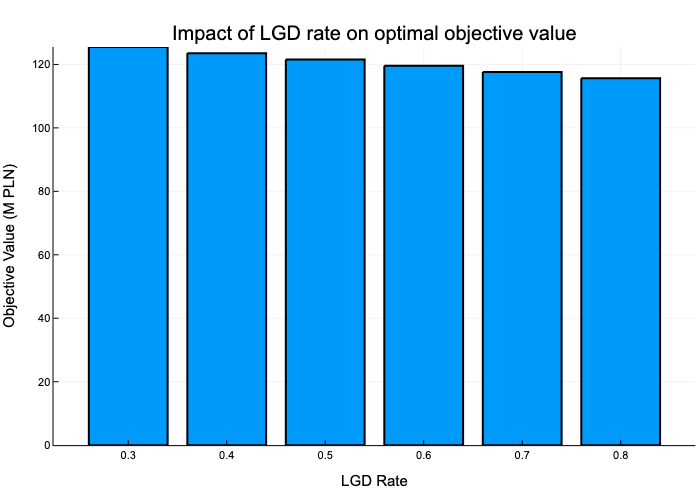

In [28]:
@df optimal_results_lgd bar(
    :lgd_rate,
    :objective_value,
    xlabel = "LGD Rate",
    ylabel = "Objective Value (M PLN)",
    title = "Impact of LGD rate on optimal objective value",
    legend = false,
    marker = :circle,
    lw = 2
)
